In [ ]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0.1"                    # GPU 0, 1번을 사용하겠다

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3                  # keras 내부에서 VGG16을 사용하도록 지정
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive                              # google colab drive mount하기
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
IMAGE_SIZE=[299, 299]           # 지정한 사이즈로 압축해라, InceptionV3는 층이 낮기 때문에 VGG16에 비해 크게 사이즈를 잡는다
train_path='/content/gdrive/My Drive/Colab Notebooks/chest_xray/train'
valid_path='/content/gdrive/My Drive/Colab Notebooks/chest_xray/val'

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

for layer in inception.layers:                     # 반복문을 돌면서 Layer를 읽어들임
  layer.trainable=False                            # InceptionV3 가장상단의 fully connected 계층을 포함시키지 않음


folders = glob('/content/gdrive/My Drive/Colab Notebooks/chest_xray/train/*')

x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(input=inception.input, output=prediction)
model.summary()
model.compile(
    loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']
)

# loss='categorical_crossentropy': 현재 가중치 세트를 평가하는데 사용한 손실함수
# optimizer = 'adam': 최적의 가중치를 검색하는데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘
# metrics=['accuracy']: 평가 척도를 나타내며 분류문제에서는 일반적으로 accuracy를 적용

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지를 마음대로 바꾸면 안되므로 몇가지 지시사항을 지정
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# rescale=1./255: 원본영상은 0-255의 RGB 개수로 구성
# shear_range=0.2: 임의의 전단 변화 범위
# zoom_range=0.2: 임의의 확대/축소
# horizontal_flip=True: True로 설정할 경우 이미지를 수평으로 뒤집음. 원본이미지에 수평 비대칭성이 없을 때 효과적으로 사용됨

test_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_directory 폴더 구조를 그대로 들고와서 ImageDataGenerator 객체의 실제 데이터를 채워줌
training_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/chest_xray/train/',
                                                 target_size=(299, 299),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/chest_xray/test/',
                                            target_size=(299, 299),
                                            batch_size=32,
                                            class_mode='categorical')

# 핵심소스
r = model.fit_generator(training_set, validation_data=test_set, epochs=10,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(test_set))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 1307s 8s/step - loss: 1.3640 - accuracy: 0.8959 - val_loss: 9.9291 - val_accuracy: 0.6506
Epoch 2/10
163/163 [==============================] - 182s 1s/step - loss: 0.9096 - accuracy: 0.9398 - val_loss: 6.9978 - val_accuracy: 0.7580
Epoch 3/10
163/163 [==============================] - 191s 1s/step - loss: 1.2639 - accuracy: 0.9304 - val_loss: 17.3006 - val_accuracy: 0.6731
Epoch 4/10
163/163 [==============================] - 191s 1s/step - loss: 0.9347 - accuracy: 0.9496 - val_loss: 3.8225 - val_accuracy: 0.7115
Epoch 5/10
163/163 [==============================] - 191s 1s/step - loss: 1.1980 - accuracy: 0.9410 - val_loss: 1.8591 - val_accuracy: 0.7869
Epoch 6/10
163/163 [==============================] - 191s 1s/step - loss: 1.2253 - accuracy: 0.9456 - val_loss: 22.2251 - val_accuracy: 0.6490
Epoch 7/10
163/163 [==============================] - 19

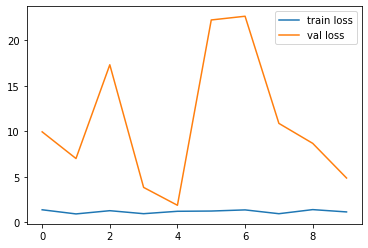

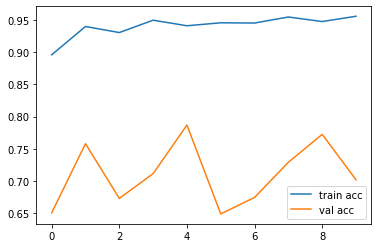

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_los')

# 정확도 그래프
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf
model.save('model_InceptionV3.h5')
from keras.models import load_model